In [1]:
import sympy as sym

In [2]:
sym.init_printing()

(u_max, u_star, rho_max,
 rho_star, A, B) = sym.symbols('u_max u_star rho_max rho_star A B')

In [3]:
eq1 = sym.Eq(0, u_max * rho_max * (1 - A * rho_max - B * rho_max**2))
eq2 = sym.Eq(0, u_max * (1 - 2 * A * rho_star - 3 * B * rho_star**2))
eq3 = sym.Eq(u_star, u_max * (1 - A * rho_star - B * rho_star**2))

In [4]:
eq1

In [5]:
eq2

In [6]:
eq3

In [7]:
eq2 - 3 * eq3

In [8]:
eq4 = sym.Eq(eq2.lhs - 3 * eq3.lhs, eq2.rhs - 3 * eq3.rhs)

In [9]:
eq4

In [10]:
eq4.simplify()

In [11]:
eq4

In [12]:
eq4.expand()

In [13]:
rho_sol = sym.solve(eq4, rho_star)[0]
rho_sol

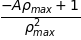

In [14]:
B_sol = sym.solve(eq1, B)[0]
B_sol

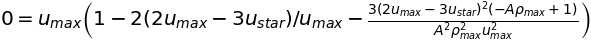

In [15]:
quadA = eq2.subs([(rho_star, rho_sol), (B, B_sol)])
quadA

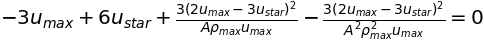

In [16]:
quadA.simplify()

In [17]:
A_sol = sym.solve(quadA, A)

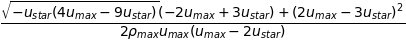

In [18]:
A_sol[0]

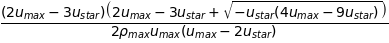

In [19]:
A_sol[1]

In [20]:
# Evaluating new flux equation

A_val_0 = A_sol[0].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_0

In [21]:
A_val_1 = A_sol[1].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_1

In [22]:
A_val = max(A_val_0, A_val_1)
A_val

In [23]:
B_val = B_sol.evalf(subs={rho_max: 10.0, A: A_val})
B_val

In [24]:
sym.init_printing(use_latex=False)

In [25]:
print(type(rho_max), type(u_max))

<class 'sympy.core.symbol.Symbol'> <class 'sympy.core.symbol.Symbol'>


In [26]:
rho_max = 10.0
u_max = 1.0

In [27]:
def flux(rho, u_max, A, B):
    """
    Computes the traffic flux for the better model.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    A : float
        Scaling coefficient for rho.
    B : float
        Scaling coefficient for rho squared.
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats.
    """
    F = rho * u_max * (1.0 - A * rho - B * rho**2)
    return F

In [28]:
import numpy as np

In [29]:
import matplotlib.pyplot as plt

In [30]:
%matplotlib inline

In [31]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [32]:
def rho_green_light(x, rho_light):
    """
    Computes the "green light" initial condition.
    It consists of a shock with a linear distribution behind it.
    
    Parameters
    ----------
    x : numpy.ndarray
        Locations on the road as a 1D array of floats.
    rho_light : float
        Car density at the stoplight.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    """
    rho = np.zeros_like(x)
    mask = np.where(x < 2.0)
    rho[mask] = rho_light * x[mask] / 2.0
    return rho

In [33]:
# Set the parameters.
nx = 81 # number of locations on the road
L = 4.0 # length of the road
dx = L / (nx - 1) # distance between two consecutive locations
nt = 30 # number of time steps to compute
rho_light = 5.0 # car density at the traffic light.

# Define the locaions on the road.
x = np.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
rho0 = rho_green_light(x, rho_light)

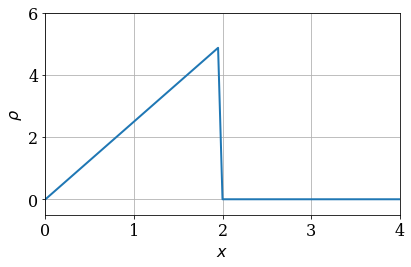

In [34]:
# Plot the initial car density on the road.
fig = plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
plt.grid()
line = plt.plot(x, rho0, 
                color='C0', linestyle='-', linewidth=2)[0]
plt.xlim(0.0, L)
plt.ylim(-0.5, 6.0)
plt.tight_layout();

In [35]:
def ftbs(rho0, nt, dt, dx, bc_value, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_value : float
        The constant density at the first station.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Advance in time.
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        # Set the left boundary condition.
        rho[0] = bc_value
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [36]:
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = ftbs(rho0, nt, dt, dx, rho0[0], u_max, A_val, B_val)

In [37]:
from matplotlib import animation
from IPython.display import HTML

In [38]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [39]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [49]:
# Applying the Lax-Friedrichs scheme.
def Lax_friedrichs(rho0, nt, dt, dx, bc_value, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_value : float
        The constant density at the first station.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Advance in time.
        rho[1:-1] = (0.5 * (rho[2:] + rho[:-2]) - 
                    dt / (2.0 * dx) * (F[2:] - F[:-2]))
        # Set the left boundary condition.
        rho[0] = bc_value
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [50]:
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = Lax_friedrichs(rho0, nt, dt, dx, rho0[0], u_max, A_val, B_val)

In [51]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [52]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())